# 3.2-Clustering and further filtering

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-10"

## Introduction

Normalize data and create embeddings for the each time point fraction

In [2]:
timepoint <- "T5"

## Libraries

In [3]:
suppressMessages(suppressWarnings({
library(Seurat)
library(here)
library(glue)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(harmony)
library(scater) 
library(scran)
}))

## Parameters

In [4]:
#dr_here(show_reason = TRUE)
source(here("SCGRES_99_100/sc_analysis/misc/paths.R"))
source(here("utils/bin.R"))

set.seed(0)

## Load data

In [5]:
seurat_obj <- readRDS(here(glue("{clust}/{robj_dir}/dimred_combined_object_{timepoint}.rds")))

## Remove potential erythrocytes

In [6]:
seurat_obj <- subset(x = seurat_obj, 
                     subset = HBM == 0 & HEMGN == 0 & HBG2 == 0)

In [7]:
seurat_obj <- DietSeurat(
  seurat_obj,
  counts = TRUE,
  data = TRUE,
  scale.data = FALSE,
  features = NULL,
  assays = NULL,
  dimreducs = FALSE,
  graphs = NULL
)

In [8]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]
seurat_obj


FALSE  TRUE 
23112  2782 


An object of class Seurat 
23112 features across 3988 samples within 1 assay 
Active assay: RNA (23112 features, 0 variable features)

### Re-do embedding

In [9]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [10]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 23112 3988 
metadata(0):
assays(2): counts logcounts
rownames(23112): AL627309.1 AL627309.5 ... AC007325.1 AC007325.4
rowData names(0):
colnames(3988): AAACCTGAGGCAGGTT-1 AAACCTGAGTCGAGTG-1 ...
  TTTGTCATCCACGAAT-1 TTTGTCATCTTCATGT-1
colData names(16): orig.ident nCount_RNA ... old.ident ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

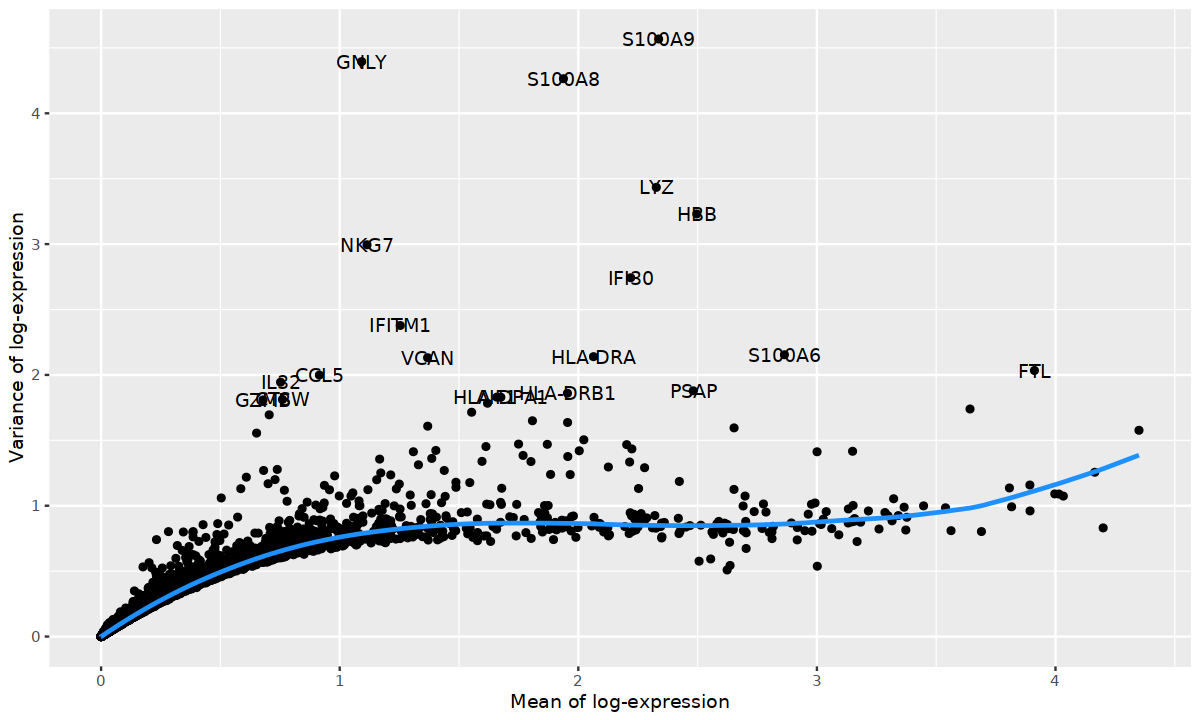

In [11]:
options(repr.plot.width = 10, repr.plot.height = 6, warn=-1,verbose = FALSE)
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [12]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 1180

In [13]:
# remove TCR genes
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]

In [14]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  IFI30, LYZ, AIF1, FTL, LST1, FCN1, S100A9, CTSS, PSAP, S100A6 
	   CYBB, PLXDC2, FTH1, GABARAP, SPI1, LYN, SERPINA1, GRN, CST3, NAMPT 
	   HLA-DRA, CD68, VIM, MNDA, S100A8, VCAN, S100A11, RBM47, MS4A6A, TKT 
Negative:  GZMA, CD247, NKG7, CTSW, PRF1, CST7, IL32, GNLY, IFITM1, CD69 
	   IL2RG, CD7, SKAP1, IL2RB, KLRK1, ZAP70, PRKCH, GZMB, SAMD3, CD96 
	   GZMM, KLRD1, SLC38A1, RHOH, KLRB1, SYNE2, GZMH, CD3E, LCK, PYHIN1 
PC_ 2 
Positive:  ALAS2, HBA2, HBA1, AHSP, HBB, CA1, HBD, SELENBP1, SLC4A1, BPGM 
	   DCAF12, BCL2L1, KRT1, SNCA, EPB42, MYL4, DMTN, OSBP2, NFIX, IFIT1B 
	   UBB, ANK1, PHOSPHO1, IFI27, GYPB, TENT5C, SLC14A1, LINC00570, KLF1, ITLN1 
Negative:  FOS, CD74, TYROBP, ZFP36, S100A4, FCER1G, IFITM3, TAGLN2, LGALS1, AHNAK 
	   IFITM2, NEAT1, UTRN, S100A11, ZEB2, ANXA1, CRIP1, FOSB, PSAP, S100A6 
	   MTRNR2L12, GNLY, S100A10, NKG7, RHOC, LYN, CTSS, PRF1, CD52, CTSW 
PC_ 3 
Positive:  HBB, S100A8, ALAS2, S100A9, HBA2, NEAT1, HBA

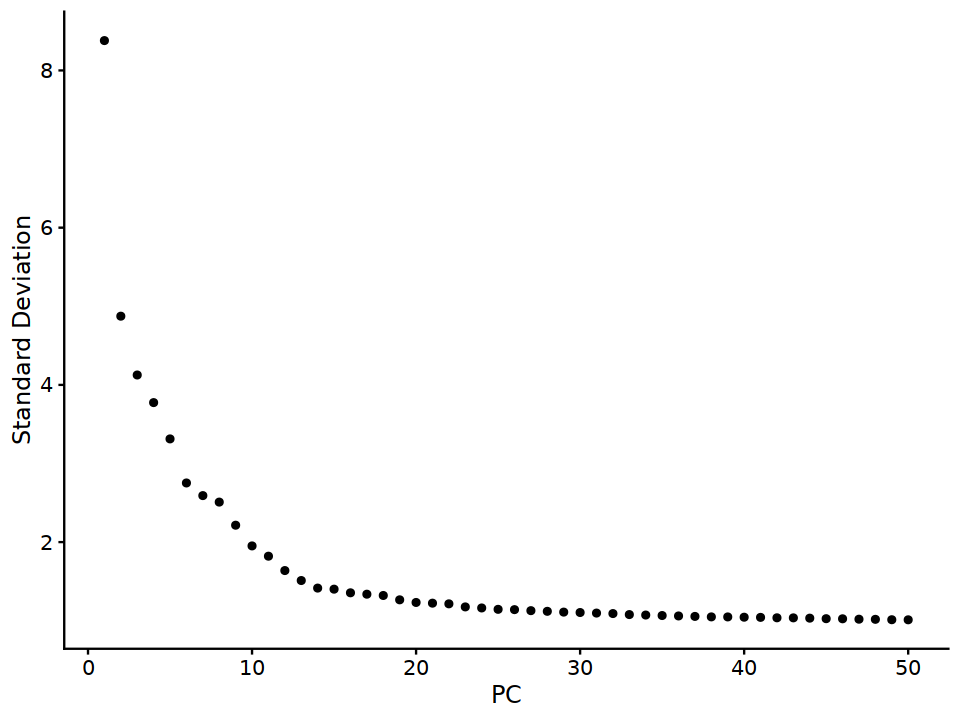

In [15]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

In [16]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:20,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

09:29:25 UMAP embedding parameters a = 0.9922 b = 1.112

09:29:25 Read 3988 rows and found 20 numeric columns

09:29:25 Using Annoy for neighbor search, n_neighbors = 30

09:29:25 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:29:25 Writing NN index file to temp file /scratch_tmp/33943067/RtmpD36F5r/file37520efcf

09:29:25 Searching Annoy index using 1 thread, search_k = 3000

09:29:26 Annoy recall = 100%

09:29:27 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

09:29:28 Initializing from normalized Laplacian + noise (using irlba)

09:29:28 Commencing optimization for 500 epochs, with 162912 positive edges

09:29:39 Optimization finished



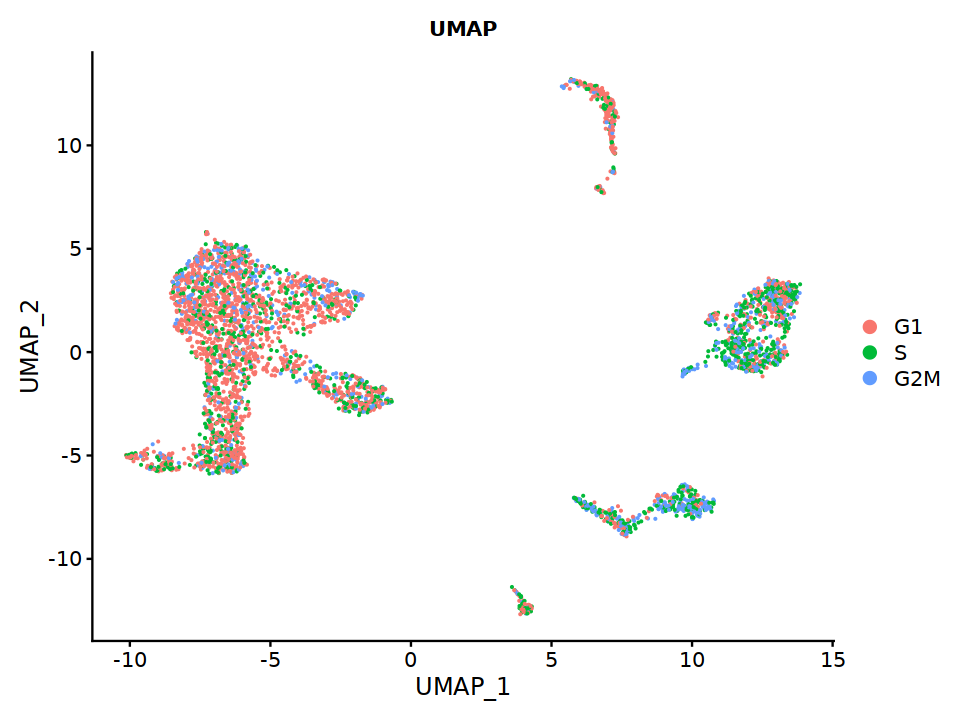

In [17]:
options(repr.plot.width = 8, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  pt.size = 0.1
) + ggtitle('UMAP') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## Remove doublets

Scores are high but wihtout markers we can't be sure those are doublets

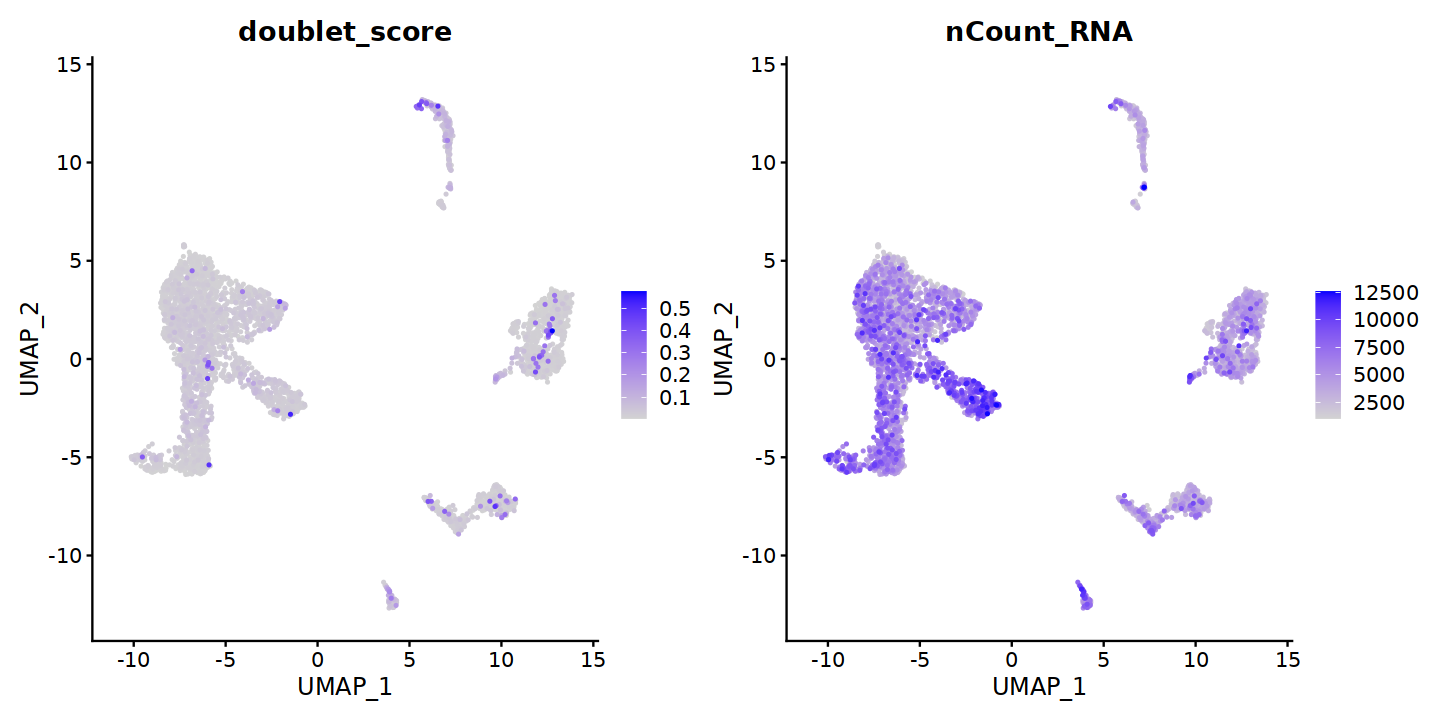

In [18]:
options(repr.plot.width = 12, repr.plot.height = 6, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, reduction = "umap", 
            feature=c("doublet_score", "nCount_RNA"), order = TRUE)

### First clustering to localize doublets

In [19]:
reso = 0.2

In [20]:
seurat_obj <- FindNeighbors(seurat_obj, reduction = "pca", dims = 1:20)
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3988
Number of edges: 142432

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9427
Number of communities: 10
Elapsed time: 0 seconds


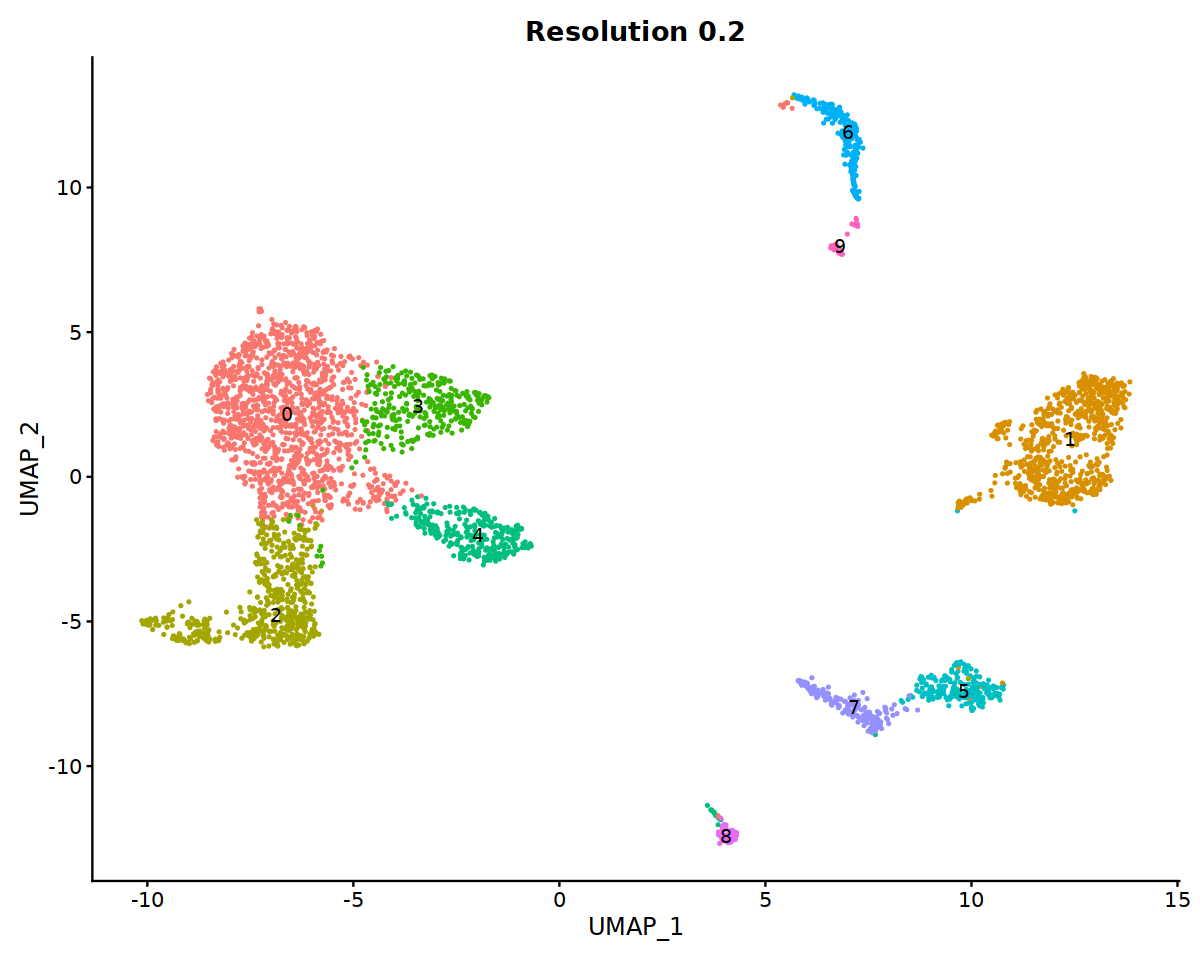

In [21]:
options(repr.plot.width = 10, repr.plot.height = 8, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

### Obtain markers to corroborate doublets by gene expression

In [22]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct=0.1, 
                              logfc.threshold=0.1, 
                              random.seed=0, 
                              max.cells.per.ident=1000,
                              only.pos=TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



low quality

In [23]:
c <- 9
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
ETV63,8.825578e-10,1.987739,0.824,0.483,2.039768e-05,9,ETV6
ELMO13,2.112476e-13,1.913273,0.882,0.524,4.882354e-09,9,ELMO1
MT-ND4L4,5.805839e-09,1.863682,0.882,0.840,1.341846e-04,9,MT-ND4L
MT-ND65,8.100179e-09,1.831842,0.882,0.671,1.872113e-04,9,MT-ND6
HDC,2.571357e-18,1.794779,0.118,0.002,5.942920e-14,9,HDC
ZBTB204,9.787015e-09,1.738670,0.676,0.337,2.261975e-04,9,ZBTB20
AGTPBP12,1.588127e-06,1.734706,0.706,0.491,3.670479e-02,9,AGTPBP1
MT-ND54,7.613260e-07,1.693521,0.882,0.893,1.759577e-02,9,MT-ND5
SSBP21,5.681116e-07,1.650488,0.588,0.275,1.313020e-02,9,SSBP2


In [24]:
c <- 6
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
HBB,1.170294e-110,7.942228,1.000,0.948,2.704783e-106,6,HBB
ALAS2,2.748218e-237,5.374980,0.990,0.032,6.351681e-233,6,ALAS2
HBA2,1.786637e-207,5.165454,1.000,0.071,4.129275e-203,6,HBA2
CA1,7.002951e-199,4.933230,0.875,0.022,1.618522e-194,6,CA1
HBD,2.512791e-180,4.890373,0.870,0.043,5.807562e-176,6,HBD
HBA1,3.613938e-214,4.298971,0.990,0.047,8.352534e-210,6,HBA1
AHSP,3.791721e-218,3.888835,0.900,0.016,8.763426e-214,6,AHSP
UBB,3.815253e-105,3.686659,0.990,0.759,8.817814e-101,6,UBB
BCL2L1,6.070809e-143,3.087538,0.905,0.128,1.403085e-138,6,BCL2L1


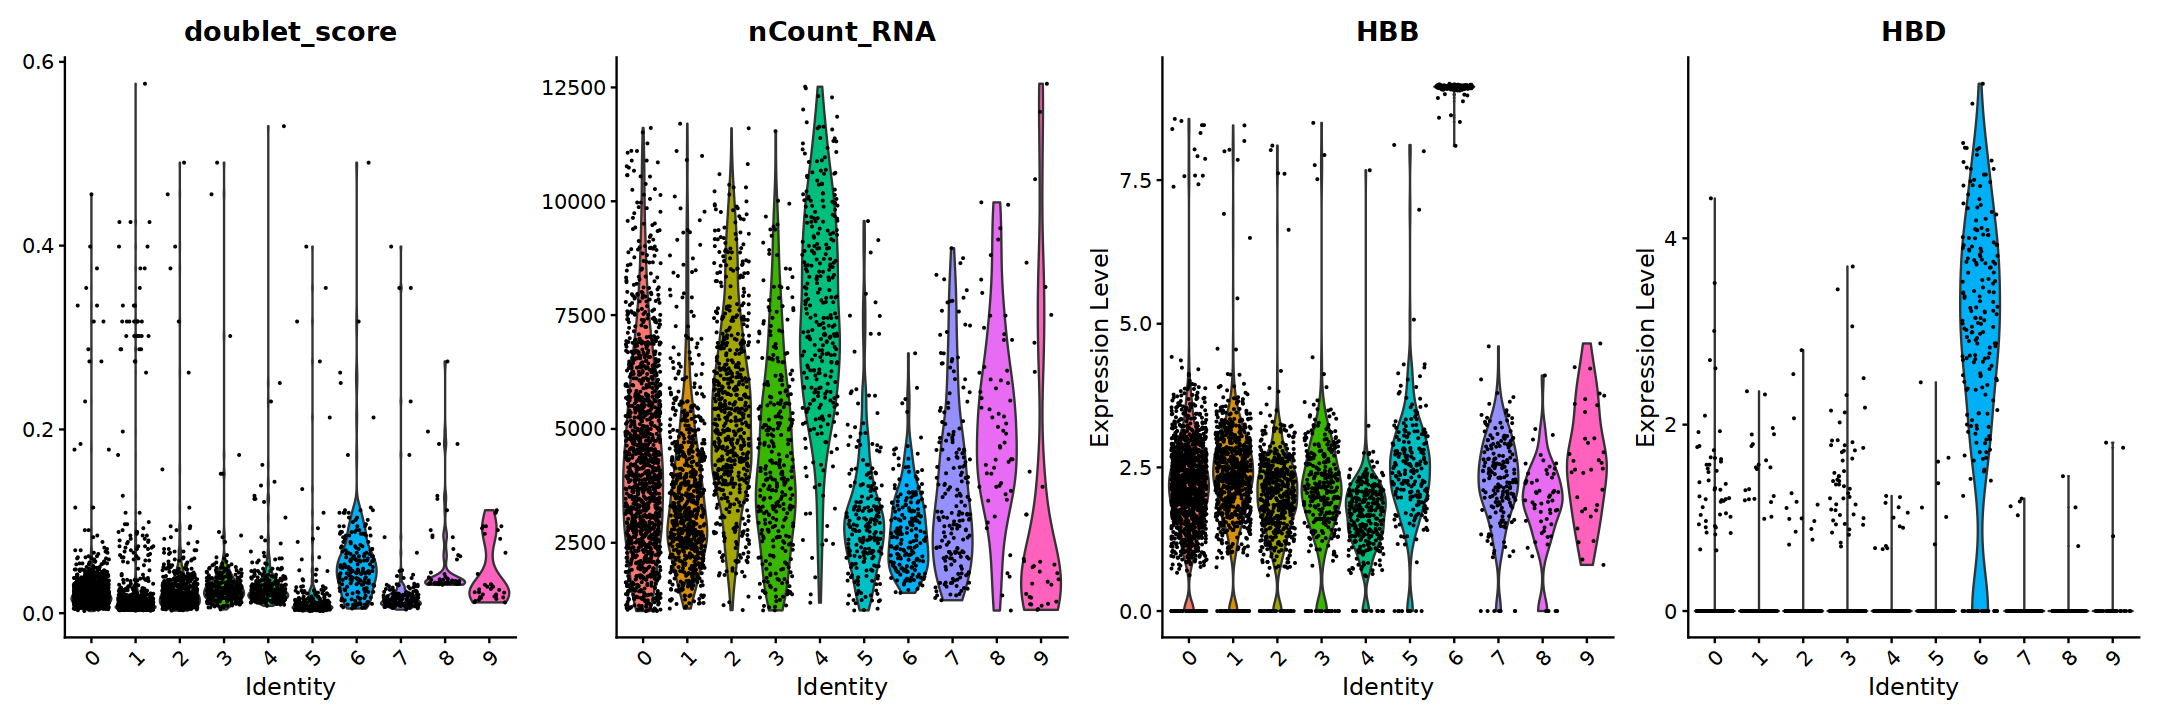

In [25]:
options(repr.plot.width = 18, repr.plot.height = 6, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj,feature=c("doublet_score", "nCount_RNA", "HBB", "HBD"), ncol=4)

### Remove doublets

Those doublets contain erytrhocytes 

In [26]:
seurat_obj <- subset(x = seurat_obj, idents=c(6,9), invert=TRUE)

In [27]:
seurat_obj <- DietSeurat(
  seurat_obj,
  counts = TRUE,
  data = TRUE,
  scale.data = FALSE,
  features = NULL,
  assays = NULL,
  dimreducs = FALSE,
  graphs = NULL
)

In [28]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]
seurat_obj


FALSE  TRUE 
23003   109 


An object of class Seurat 
23003 features across 3754 samples within 1 assay 
Active assay: RNA (23003 features, 0 variable features)

## Re-do embedding and clustering

In [29]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [30]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 23003 3754 
metadata(0):
assays(2): counts logcounts
rownames(23003): AL627309.1 AL627309.5 ... AC007325.1 AC007325.4
rowData names(0):
colnames(3754): AAACCTGAGGCAGGTT-1 AAACCTGAGTCGAGTG-1 ...
  TTTGTCATCCACGAAT-1 TTTGTCATCTTCATGT-1
colData names(18): orig.ident nCount_RNA ... seurat_clusters ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

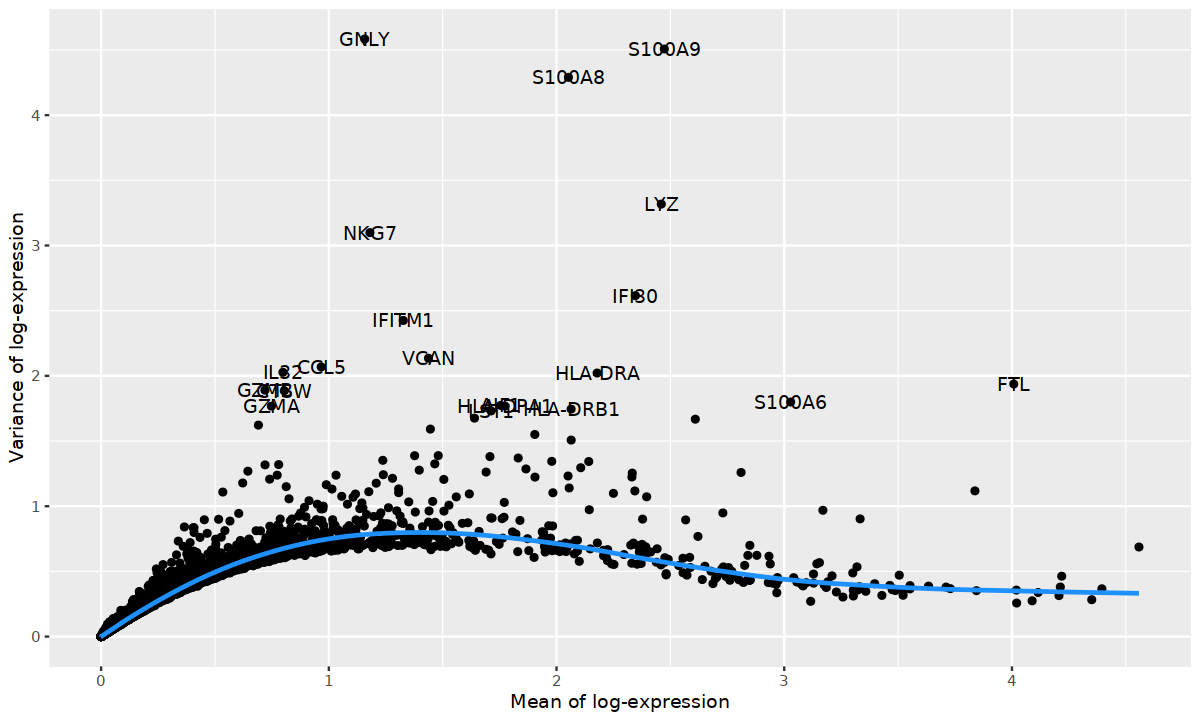

In [31]:
options(repr.plot.width = 10, repr.plot.height = 6, warn=-1,verbose = FALSE)
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [32]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 1008

In [33]:
# remove TCR genes
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]

In [34]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  IFI30, LYZ, FTL, AIF1, LST1, S100A6, PSAP, CTSS, FCN1, S100A9 
	   FTH1, GABARAP, CYBB, PLXDC2, LYN, SPI1, GRN, SERPINA1, S100A11, HLA-DRA 
	   VIM, NAMPT, OAZ1, CD68, MNDA, S100A8, VCAN, MS4A6A, HLA-DRB1, HLA-DQB1 
Negative:  GZMA, NKG7, CD247, CTSW, CST7, PRF1, IFITM1, IL2RG, GNLY, IL32 
	   CD69, CD7, SKAP1, IL2RB, KLRK1, PRKCH, ZAP70, GZMB, SAMD3, CD96 
	   GZMM, SLC38A1, KLRD1, RHOH, KLRB1, GZMH, SYNE2, CD3E, LCK, EVL 
PC_ 2 
Positive:  NEAT1, IFITM3, S100A9, ANXA1, S100A8, DPYD, ARHGAP26, FCN1, GNLY, VCAN 
	   TYROBP, IFITM2, CD14, S100A4, KLRD1, S100A12, PRF1, FOS, SERPINA1, KLRC1 
	   FCAR, LYZ, NKG7, IL2RB, S100A11, CXCL8, CCL5, PLXDC2, KLRF1, MNDA 
Negative:  JCHAIN, LILRA4, CLEC4C, NIBAN3, SPIB, SERPINF1, RHEX, IGKC, AC023590.1, MZB1 
	   PTPRS, DERL3, FAM160A1, LINC01374, PLD4, RGS7, LINC01478, TPM2, CUX2, COBLL1 
	   SMPD3, MYBL2, ALOX5AP, EPHB1, LTB, STMN1, CD74, HLA-DQA1, TCL1A, RPLP0 
PC_ 3 
Positive:  FCER1G, TYROBP,

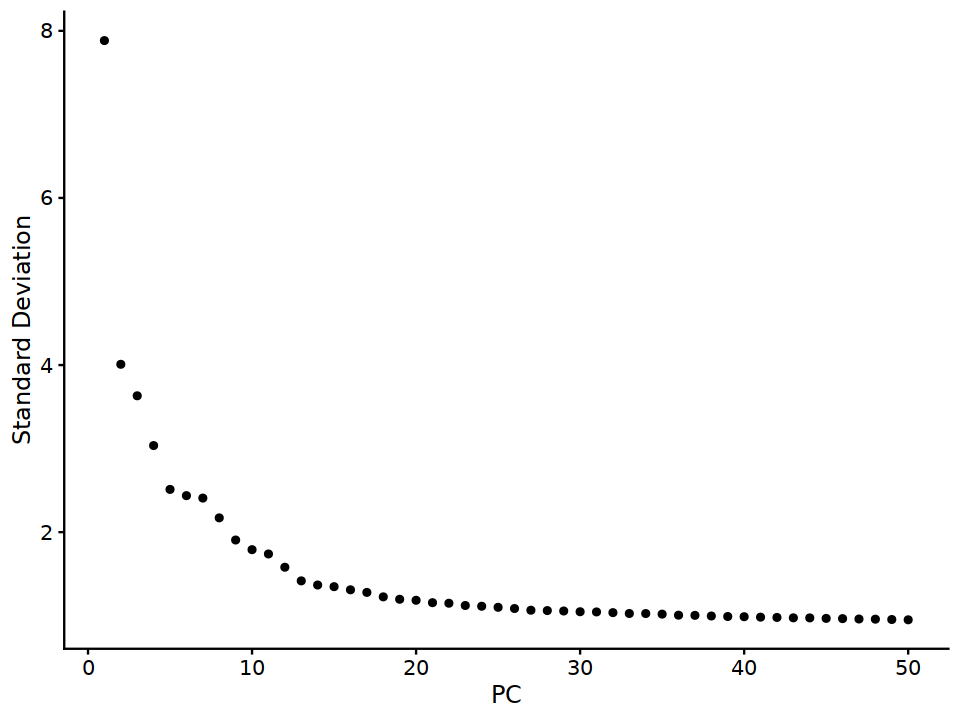

In [35]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

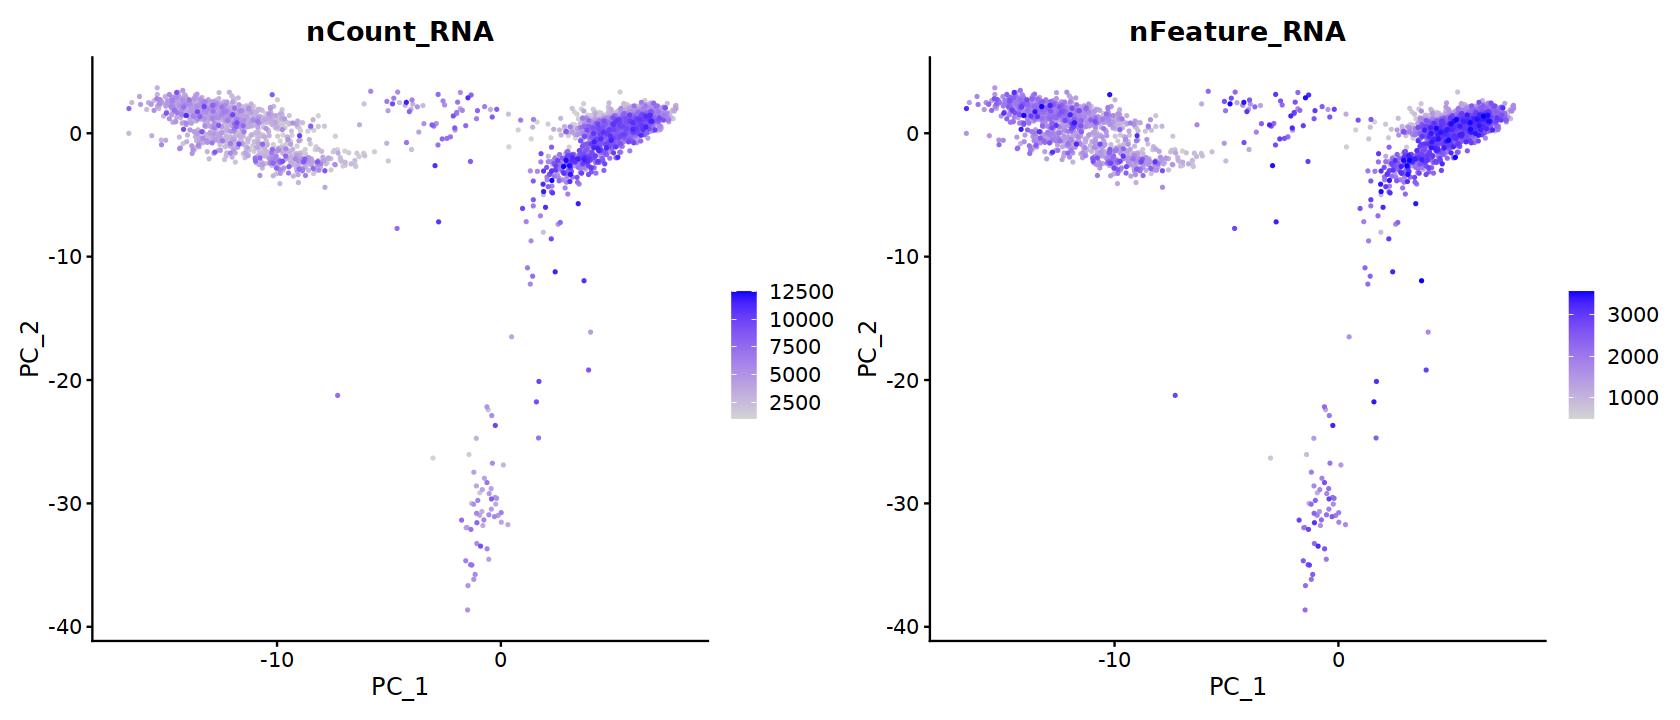

In [36]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = seurat_obj, reduction = "pca",
        features = c("nCount_RNA","nFeature_RNA"), order=T)

In [37]:
comp=20

In [38]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

09:31:16 UMAP embedding parameters a = 0.9922 b = 1.112

09:31:16 Read 3754 rows and found 20 numeric columns

09:31:16 Using Annoy for neighbor search, n_neighbors = 30

09:31:16 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:31:16 Writing NN index file to temp file /scratch_tmp/33943067/RtmpD36F5r/file3752038e9ebbe

09:31:16 Searching Annoy index using 1 thread, search_k = 3000

09:31:17 Annoy recall = 100%

09:31:18 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

09:31:19 Initializing from normalized Laplacian + noise (using irlba)

09:31:19 Commencing optimization for 500 epochs, with 154988 positive edges

09:31:30 Optimization finished



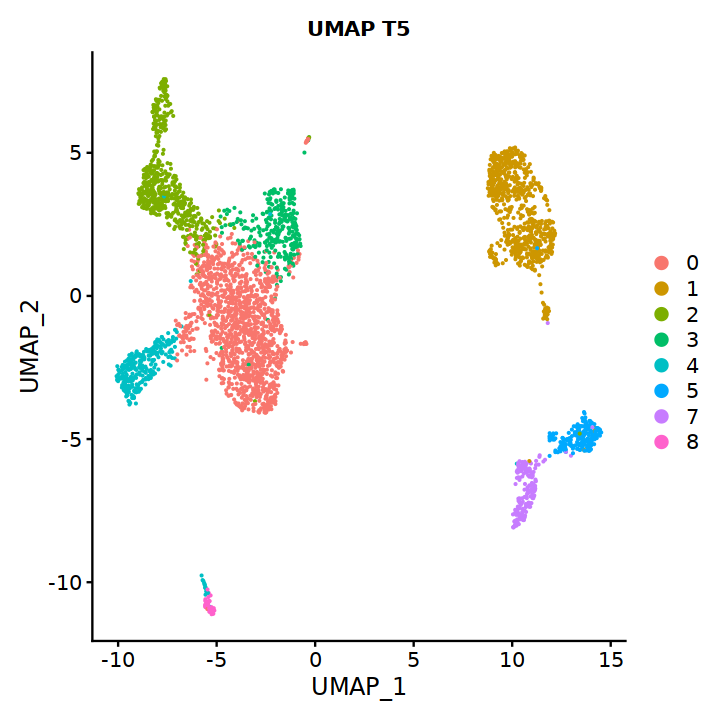

In [39]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

In [40]:
# Find the K-nearest neighbors
seurat_obj <- FindNeighbors(seurat_obj, reduction = "pca", dims = 1:30)
# Find clusters at different resolutions
clusters_df <- cluster_diff_resolutions(
  seurat_obj = seurat_obj,
  min_resolution = 0.1,
  max_resolution = 1.0,
  step = 0.1
)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3754
Number of edges: 154760

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9591
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3754
Number of edges: 154760

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9337
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3754
Number of edges: 154760

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9139
Number of communities: 10
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3754
Number of edges: 154760

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8970
Number of communities: 11
Elapsed time: 0 seconds
Modularity Optimiz

In [41]:
list_plots <- lapply(unique(clusters_df$resolution), function(x) {
  p <- add_reso_results(seurat_obj, clusters_df, resolution=x)
  umap <- DimPlot(p, reduction = "umap", 
                  group.by=glue::glue("seurat_clusters")) +
    labs(title=glue::glue("Resolution {x}"))
  return(umap)
})

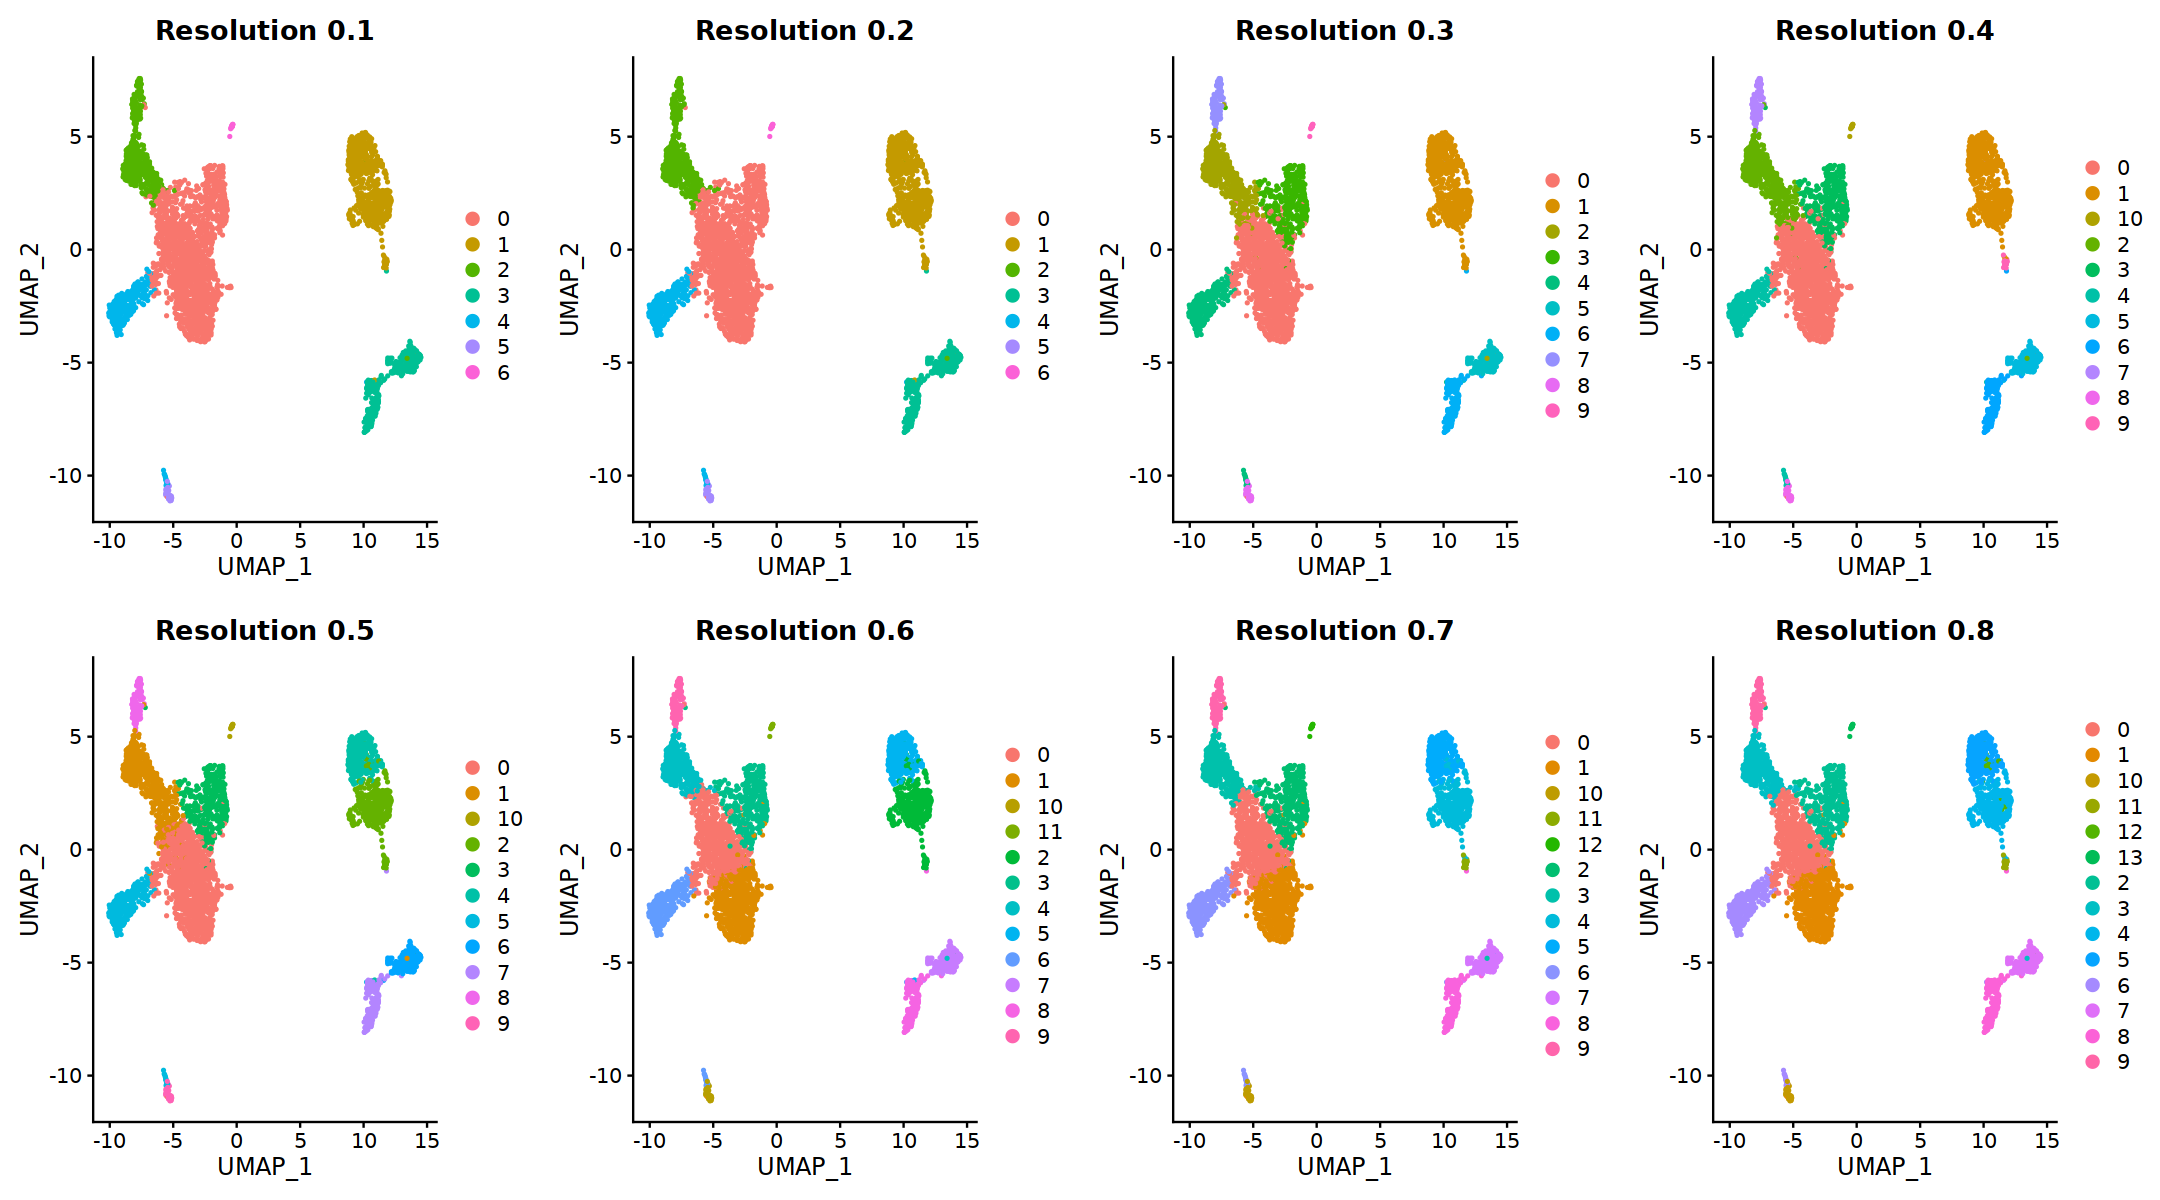

In [42]:
options(repr.plot.width = 18, repr.plot.height = 10, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol=4,
                   nrow=2)
cp

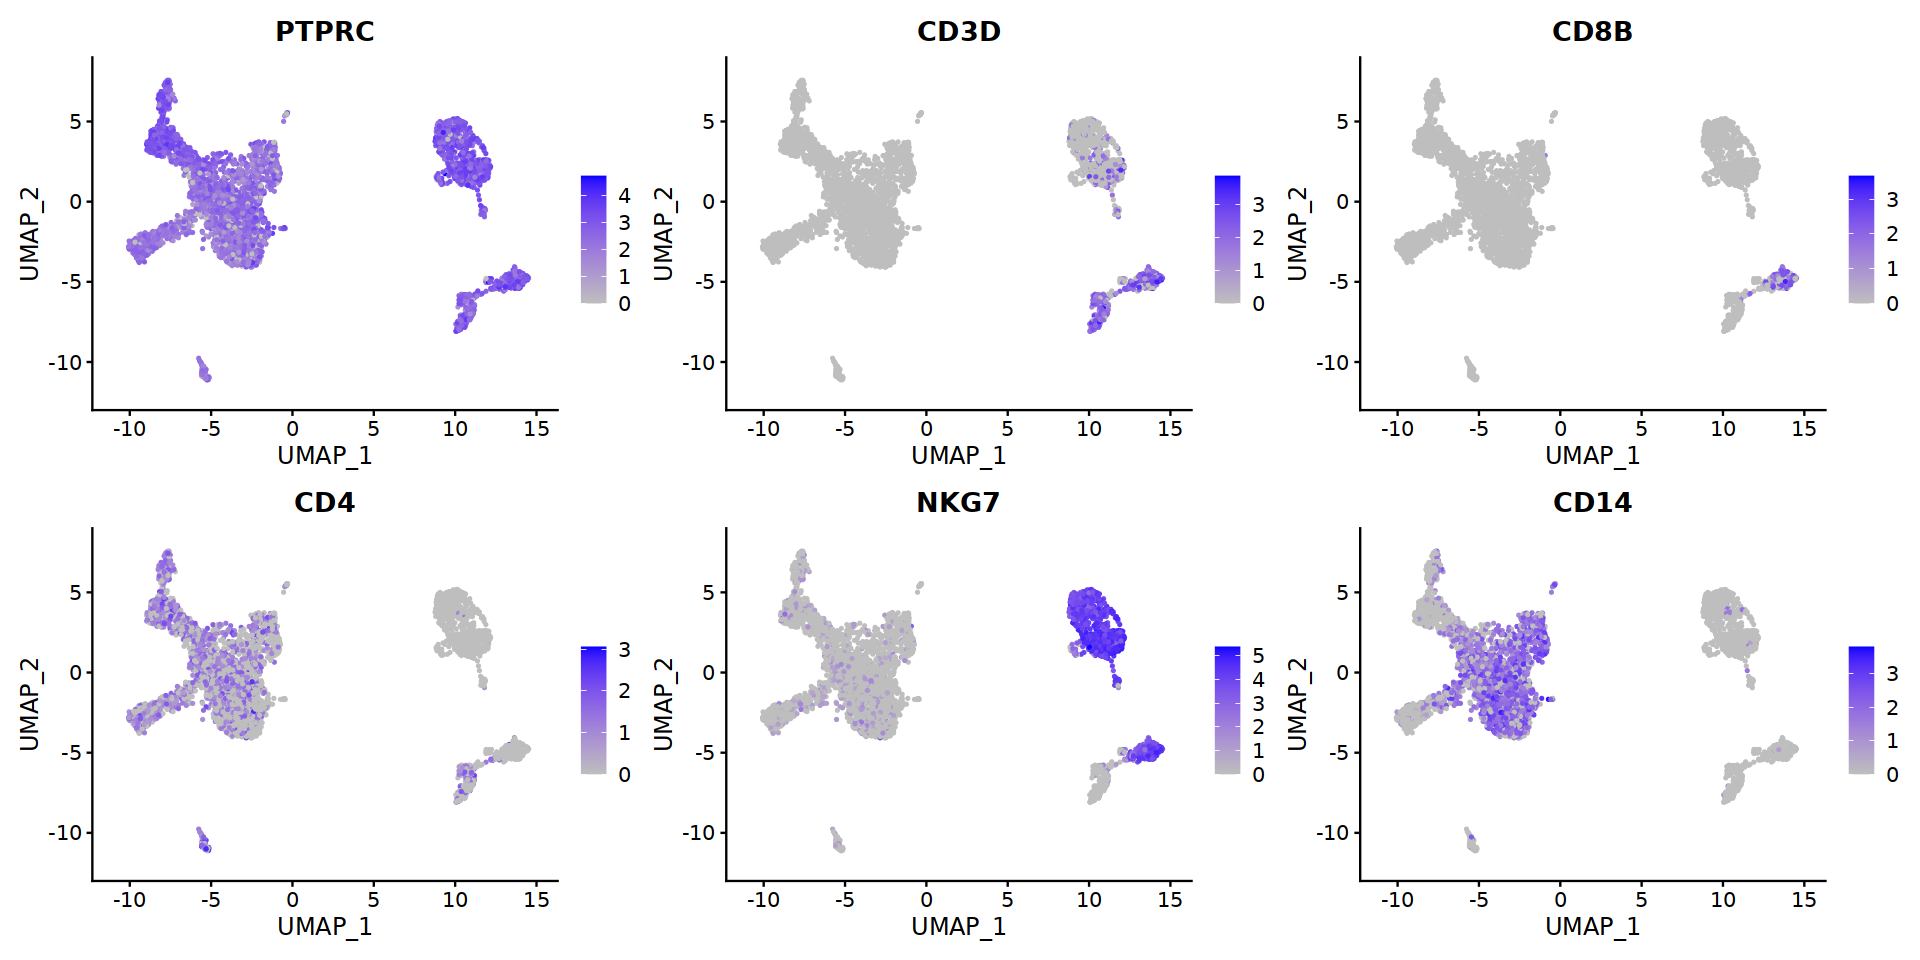

In [43]:
options(repr.plot.width = 16, repr.plot.height = 8, warn=-1,verbose = FALSE)
genes = c("PTPRC", "CD3D", "CD8B", "CD4", "NKG7","CD14")

FeaturePlot(seurat_obj, reduction = "umap", cols = c("grey", "blue"),
            feature=genes, order = FALSE, ncol=3)

In [44]:
reso = 0.2

In [45]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3754
Number of edges: 154760

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9337
Number of communities: 7
Elapsed time: 0 seconds


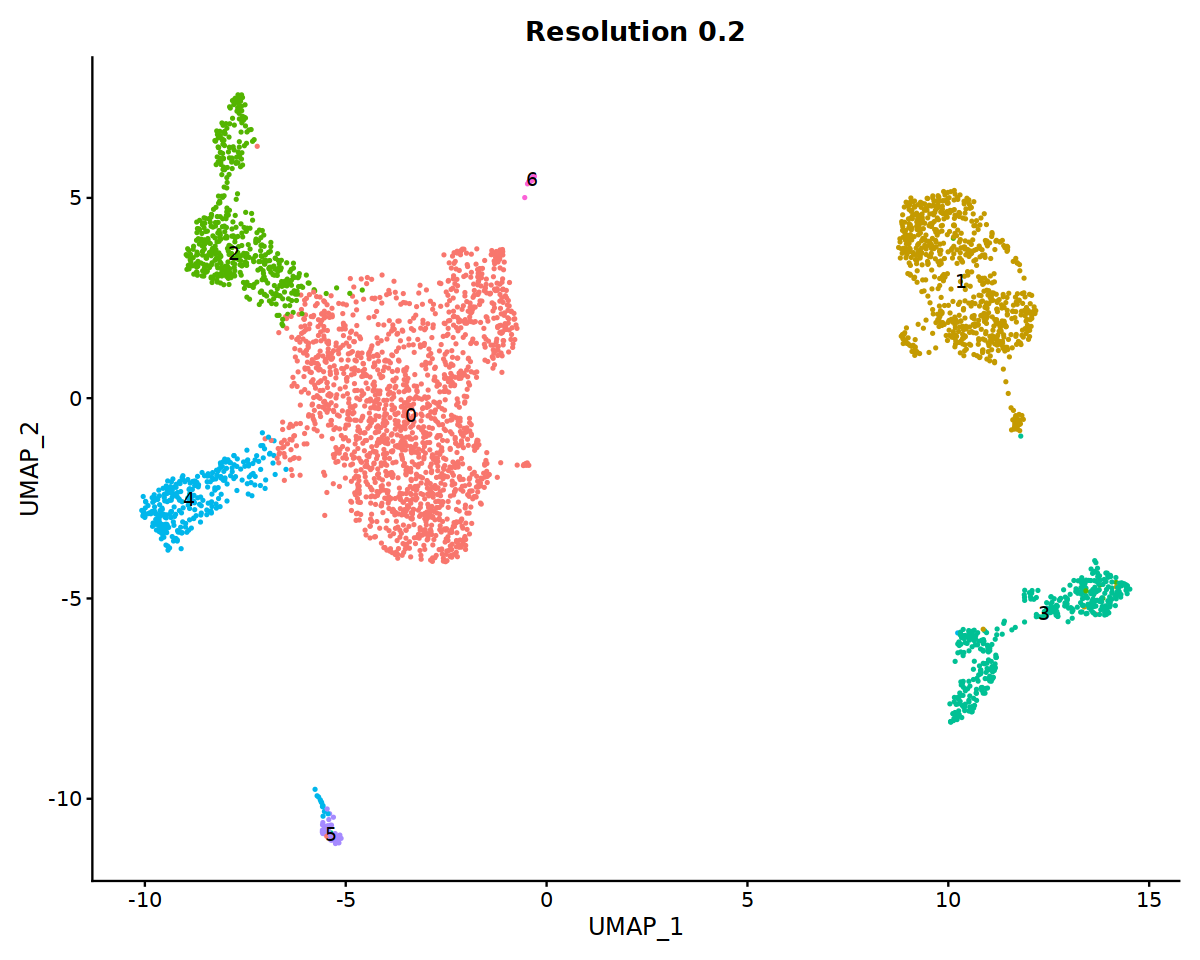

In [46]:
options(repr.plot.width = 10, repr.plot.height = 8, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

In [47]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, 
                              logfc.threshold = 0.1, only.pos = T,
                              random.seed=0, max.cells.per.ident=1000)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



# Save

In [48]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/3.2-clustering_{timepoint}.rds")))

In [49]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-clustering_{timepoint}.csv")))

# Session Info

In [50]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_